# ModelAnalysis

#### Jupyter notebook with all the functions and the implementation of the Sklearn model

### Import necessary libraries

In [1]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

# 1. Read the original data

In [2]:
# Establish a connection to the SQLite database
conn = sqlite3.connect(os.path.join('..', 'laliga.sqlite'))
#Read into pandas dataframe 
df = pd.read_sql_query("SELECT * FROM Matches", conn)
pd.set_option('display.max_colwidth', None)

# 2. Create the necessary functions to modify the original df and get more relevant parametters

### Process the raw data

In [3]:
# Creates a new columns with the result of the match
def result_calculator(row):
    if row['home_score'] > row['away_score']:
        return 1
    elif row['home_score'] < row['away_score']:
        return 2
    else:
        return 'X'

# Eliminate non relevant rows and make some adjusts
def process_and_filter_data(input_df):    
    
    # Create a copy of the df, and erase the Nones
    filtered_score_df = input_df[input_df['score'].notna()].copy()
    
    # Split the score to make it easier to read
    split_scores = filtered_score_df['score'].str.split(':', expand=True).astype(int)
    
    # Assign the split scores to new columns
    filtered_score_df['home_score'] = split_scores[0]
    filtered_score_df['away_score'] = split_scores[1]
    filtered_score_df['result'] = filtered_score_df.apply(result_calculator, axis=1)
    return filtered_score_df    

### Separate information by teams

In [4]:
# Get the results of the matches for each team
def separate_wins_loses_ties(df_filtered):
    # Build three columns, one for each possible result
    df_filtered['Win_local'] = np.where(df_filtered['home_score'] > df_filtered['away_score'], 1, 0)
    df_filtered['Win_away'] = np.where(df_filtered['home_score'] < df_filtered['away_score'], 1, 0)
    df_filtered['Ties'] = np.where(df_filtered['home_score'] == df_filtered['away_score'], 1, 0)
    
    # Combine home and away matches to identify all matches for each team
    df_teams = pd.concat([df_filtered.rename(columns={'home_team': 'team', 'Win_local': 'Win','Win_away':'Lose', 'home_score' : 'GF', 'away_score': 'GA',}),
                             df_filtered.rename(columns={'away_team': 'team', 'Win_away': 'Win','Win_local':'Lose', 'home_score' : 'GA', 'away_score': 'GF'})], ignore_index=True)
    
    return(df_teams)

### 2.1. Get all information from the previous relevant seasons

In [5]:
# Split the season into 2 new columns, one for each year
def split_season(df):
    df[['date1', 'date2']] = df['season'].str.split('-', expand=True)
    df['date1'] = df['date1'].astype(int)
    df['date2'] = df['date2'].astype(int)
    #df.drop('season', axis=1, inplace=True)
    return df

In [6]:
# Get a dataframe with the summary information of previous seasons
def process_df_previous_seasons(X_train):
    df_all_summary = separate_wins_loses_ties(X_train) [['season','division','team','GF','GA','Win','Lose','Ties']]
    df_all_summary = df_all_summary.groupby(['season','division','team'])[['GF', 'GA', 'Win', 'Lose', 'Ties']].sum().reset_index()
    df_all_summary['Pts']=3*df_all_summary['Win'] + df_all_summary['Ties']
    df_all_summary['GD'] = df_all_summary['GF'] - df_all_summary['GA']
    df_all_summary = split_season(df_all_summary)
    df_all_summary = df_all_summary[['season','division','team','Pts','GD','date1']]
    return df_all_summary

In [7]:
# Function that gives the cumulative sum up to number n, used in the ponderation of the seasons result
def cumsum_n(n):
    return n * (n + 1) // 2

def get_mean_parameter(df_all_summary, team, season, parameter, division):
    # Get information from the previous seasons
    season_format = int(season.split('-')[0])
    team_info = df_all_summary[(df_all_summary['team'] == team) & (((season_format-5) <= df_all_summary['date1'])) & (season_format > df_all_summary['date1'])].reset_index()
    
    # If there is no previous information, assume the mean. It could be ponderated
    tam_df = team_info.shape[0]
    if tam_df == 0:
        mean_parameter_team = df_all_summary[parameter].mean() 
    else:
        team_info['parameter_pondered'] = team_info[parameter] * (team_info.index + 1)
        mean_parameter_team = team_info['parameter_pondered'].sum() / cumsum_n(tam_df)
    
    # REVISAR, lo metería en el pondered según la liga. Liga 1 vale el dobel
    if division == 2 and parameter == 'Pts':
        mean_parameter_team -= df_all_summary[parameter].mean() * 2
    
    return mean_parameter_team

def get_teams_last_mean_dif_p(row_original, df_all_summary, parameters):
    # Get info from the row
    row = row_original.copy()
    home_team = row['home_team']
    away_team = row['away_team']
    season = row['season']
    division = row['division']

    # Calculate the difference between teams of each parameter
    for parameter in parameters:
        home_mean = get_mean_parameter(df_all_summary, home_team, season, parameter, division)
        away_mean = get_mean_parameter(df_all_summary, away_team, season, parameter, division)
        
        row[f'{parameter}_mean_home'] = home_mean
        row[f'{parameter}_mean_away'] = away_mean
        row[f'dif_{parameter}_mean'] = home_mean - away_mean

    return row

### 2.2. Get parameters from the same season

In [8]:
def process_df_current_season(X_train):
    # Process raw data and sort it by season, division and mathcday
    df_filtered = process_and_filter_data(X_train)
    df_current_season = separate_wins_loses_ties(df_filtered) [['season','division','team','GF','GA','Win','Lose','Ties','matchday']]
    df_current_season = df_current_season.sort_values(by = ['season','division','matchday'], ascending = [False,True,True])
    
    # Calculate if there is a win, a lose or a tie
    df_current_season['Last'] = df_current_season['Win'] - df_current_season['Lose']
    
    # Calculate the cumsum of each of the features
    grouped = df_current_season.groupby(['season', 'division', 'team'])
    features = ['GF','GA','Win','Lose','Ties']
    for feature in features:
        df_current_season[feature] = grouped[feature].cumsum()

    #Calculate derivated features
    df_current_season['Pts'] = 3 * df_current_season['Win'] + df_current_season['Ties']
    df_current_season['GD'] = df_current_season['GF'] - df_current_season['GA']
    
    # Sort the data
    df_current_season = df_current_season.sort_values(by = ['season','division','matchday','Pts'], ascending=[False,True,False,False])

    # Calculate the result of the last 5 matches and the sum of this 5 matches
    for i in range(5):
        df_current_season[f"last_{i}"] = df_current_season.groupby(['division','season' ,'team'])['Last'].shift(-i)
        
    df_current_season["last_5"] = df_current_season[[f"last_{i}" for i in range(5)]].agg(lambda x: [i for i in x if not pd.isna(i)],axis=1)
    df_current_season['Sum'] = df_current_season['last_5'].apply(sum)

    # ATENCIÓN: No se que hace
    features=['GD','Pts','Sum']
    for feature in features:
        df_current_season[feature]= df_current_season.groupby(['division','season' ,'team'])[feature].shift(-1)

    # Null the rest of the information
    df_current_season['N'] = df_current_season['matchday'].apply(lambda x: 1 if x == 0 else 1)
    for feature in features: 
        df_current_season[feature] = df_current_season['N'] * df_current_season[feature]

    # Get the final dataframe
    df_current_season.fillna(0, inplace=True)
    df_current_season = df_current_season[['season','matchday','team','Pts','Sum','GD']]
    return df_current_season

In [9]:
def get_matchday_info(row_original, df_all):
    # Get info from the row
    row = row_original.copy()
    home_team = row['home_team']
    away_team = row['away_team']
    season = row['season']
    matchday = row['matchday']

    # Filter by season and matchday
    df_all_matchday = df_all[(df_all['season'] == season) & (df_all['matchday'] == matchday)]
    
    # Get info for each team
    home_info = df_all_matchday[df_all_matchday['team'] == home_team].iloc[0]
    away_info = df_all_matchday[df_all_matchday['team'] == away_team].iloc[0]

    # Get the features
    row['yet_pts_dif'] = home_info['Pts'] - away_info['Pts']
    row['yet_sum5_dif'] = home_info['Sum'] - away_info['Sum']
    row['yet_GD_dif'] = home_info['GD'] - away_info['GD']

    return row

# 3. Process the data for the model

In [10]:
# Separate the sets for training and test the model
def separate_train_test(input_df):
    X = input_df.iloc[:, :-1] 
    y = input_df['result']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [11]:
parameters_to_calculate = ['Pts', 'GD']
def process_X(X_train):
    clean_X_train = X_train[['season','division','matchday','home_team','away_team']]
    X_process_train = clean_X_train.apply(lambda row: get_teams_last_mean_dif_p(row, df_previous, parameters_to_calculate), axis=1)
    X_process_train = X_process_train.apply(lambda row: get_matchday_info(row, df_current), axis=1)
    X_process_train = X_process_train[['dif_GD_mean','dif_Pts_mean','yet_GD_dif','yet_pts_dif','yet_sum5_dif']]
    return X_process_train

In [12]:
df_aux = process_and_filter_data(df)
X_train, X_test, y_train, y_test = separate_train_test(df_aux)
df_previous = process_df_previous_seasons(df_aux)
df_current = process_df_current_season(df_aux)

In [13]:
X_process_train = process_X(X_train)

In [14]:
X_process_test = process_X(X_test)

In [15]:
y_train_str = y_train.astype(str)
y_test_str = y_test.astype(str)

## 4. Model construction

For building the model three different classifiers have been used: Gaussian Naïve Bayes, Random Forest and Gradient Boosting. Each classifier has its advantages and disadvantages, and the choice between them depends on the specific problem and dataset characteristics. It is common to try out various algorithms and compare their results before selecting the final model for implementation.

Since the class "1" is more represented than the orther, Random Forest and Gradient Boosting are good candidates, but they would be evaluated and compared with GaussianNB.

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

dict_weights = {"1":0.5, "2": 1, "X": 1}

# Build the classifiers
clf_NB = GaussianNB()
clf_RF = RandomForestClassifier(class_weight = dict_weights, n_estimators = 100, max_depth = None)
clf_GB = GradientBoostingClassifier(n_estimators = 100, max_depth = 3, random_state = 42)

# Train the classifiers
clf_NB.fit(X_process_train, y_train_str)
clf_RF.fit(X_process_train, y_train_str)
clf_GB.fit(X_process_train, y_train_str)

GradientBoostingClassifier(random_state=42)

In [17]:
y_pred_NB = clf_NB.predict(X_process_test)
y_pred_RF = clf_RF.predict(X_process_test)
y_pred_GB = clf_GB.predict(X_process_test)

#### In order to evaluate the quality of the model, four metrics have been used 
- Accuracy: represents the number of succesful predictions out of the total.
- Precision: true positive rate compared to predicted positives.
- Recall: Represents the true positives among the total of positives (true and false).
- F1 - Score: It combines precision and recall in a single parameter.

All this parameters can be obtained directly with the library sklearn.metrics. The option weighted is used because the clases are unbalenced, the parameters are calculated for each class and then the weighted mean is calculated. 

In [18]:
# Confusion Matrix Functions
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Quality metrics of the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

### Naïves Bayes Classifier Evaluation

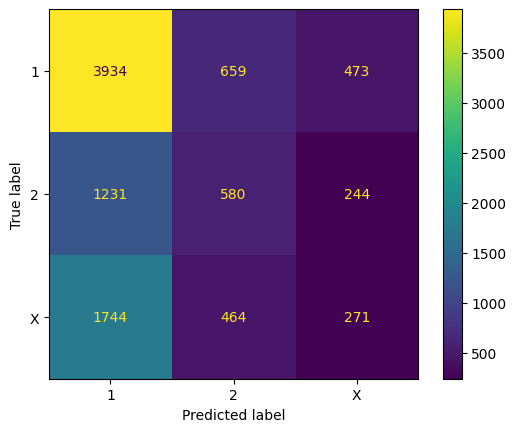

In [19]:
cm = confusion_matrix(y_true = y_test_str, y_pred = y_pred_NB, labels = ['1','2','X'])
cm_display = ConfusionMatrixDisplay(cm, display_labels=('1','2','X')).plot()

In [20]:
print('Accuracy: %.3f' % accuracy_score(y_true = y_test_str, y_pred = y_pred_NB))
print('Precision: %.3f' % precision_score(y_true = y_test_str, y_pred = y_pred_NB, average = 'weighted'))
print('Recall: %.3f' % recall_score(y_true = y_test_str, y_pred = y_pred_NB, average = 'weighted'))
print('F1-Score: %.3f' % f1_score(y_true = y_test_str, y_pred = y_pred_NB, average = 'weighted'))

Accuracy: 0.498
Precision: 0.444
Recall: 0.498
F1-Score: 0.453


### Random Forest Classifier Evaluation

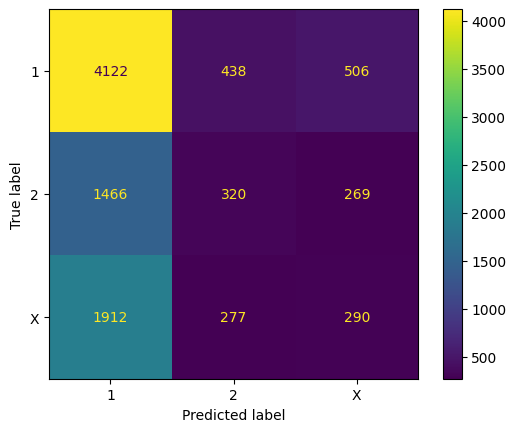

In [21]:
cm = confusion_matrix(y_true = y_test_str, y_pred = y_pred_RF, labels = ['1','2','X'])
cm_display = ConfusionMatrixDisplay(cm, display_labels=('1','2','X')).plot()

In [22]:
print('Accuracy: %.3f' % accuracy_score(y_true = y_test_str, y_pred = y_pred_RF))
print('Precision: %.3f' % precision_score(y_true = y_test_str, y_pred = y_pred_RF, average = 'weighted'))
print('Recall: %.3f' % recall_score(y_true = y_test_str, y_pred = y_pred_RF, average = 'weighted'))
print('F1-Score: %.3f' % f1_score(y_true = y_test_str, y_pred = y_pred_RF, average = 'weighted'))

Accuracy: 0.493
Precision: 0.427
Recall: 0.493
F1-Score: 0.433


### Gradient Descend Classifier Evaluation

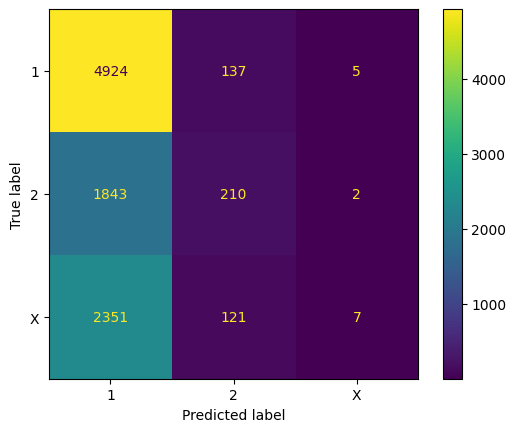

In [23]:
cm = confusion_matrix(y_true = y_test_str, y_pred = y_pred_GB, labels = ['1','2','X'])
cm_display = ConfusionMatrixDisplay(cm, display_labels=('1','2','X')).plot()

In [24]:
print('Accuracy: %.3f' % accuracy_score(y_true = y_test_str, y_pred = y_pred_GB))
print('Precision: %.3f' % precision_score(y_true = y_test_str, y_pred = y_pred_GB, average = 'weighted'))
print('Recall: %.3f' % recall_score(y_true = y_test_str, y_pred = y_pred_GB, average = 'weighted'))
print('F1-Score: %.3f' % f1_score(y_true = y_test_str, y_pred = y_pred_GB, average = 'weighted'))

Accuracy: 0.536
Precision: 0.510
Recall: 0.536
F1-Score: 0.403


As we can observe, Gradient Boosting Classifier provide the best metrics except for F1-Score, that may be the most interesting one. Both Gradient Boosting Classifier and RandomForestClassifier predict too much results on class "1", so they get great results in Accuracy, Precision and Recall, but no in F1-Score. 

Our model would take the Naïve Bayes Classifier, because it has the highest F1-Score and it does not predict as much class "1" as the others